In [41]:
import time
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from copy import deepcopy
import socket
import os
import re #Searches strings
import operator
from collections import OrderedDict #Allows the use of Ordered Dictionaries
from difflib import SequenceMatcher #Allows to quickly compare two strings to see how similar they are

#Desired energy
target_energy = 190 #Target energy in microjoules
#Desired tolerance
tolerance = 0.025 #2.5% plus or minus

interpolation_data = OrderedDict()
#Measured energy values at different attenuator degrees
interpolation_data[0]  = 187
interpolation_data[2]  = 192
interpolation_data[4]  = 205
interpolation_data[6]  = 226
interpolation_data[8]  = 254
interpolation_data[10] = 310
interpolation_data[12] = 360
interpolation_data[14] = 420
interpolation_data[16] = 480
interpolation_data[18] = 560
interpolation_data[20] = 650
#Power in the dragonview program at the time of measurement
interpolation_data['power'] = 2.01


def sine_func(x, a, b, c):
    """
    x (float) -The angle in degrees
    a,b,c (float) -Curve fitting parameters
    """
    return a + b * np.sin(((x-c)*np.pi*4/180))


def find_sine_params(interpolation_data):
    """
    Function to find the best fit params for the sine_func
    Requires:
    interpolation_data (OrderedDict) -Contains actual measurement data
    """
    count = 0
    x_vals = np.zeros(11)
    y_vals = np.zeros(11)

    for keys, values in interpolation_data.items():
        if keys != 'power':
            x_vals[count] = float(keys)
            y_vals[count] = float(values)
        count += 1
    print(y_vals)
    popt, pcov = curve_fit(sine_func, 
                x_vals, 
                y_vals, 
                p0 = (0, 0, 0),
                maxfev = 10000,
                #lmbounds = ([0.,0., 0.], [y_vals[0] * 1.20, y_vals[-1] * 1.20, 45.0]),
                method = 'lm') #lm trf dogbox
        
    plt.plot(x_vals, sine_func(x_vals, *popt), 'r-', label='Fitted curve') 
    plt.plot(x_vals, y_vals, 'b.', label='Measured data')
    plt.xlabel('Attenuator degrees')
    plt.ylabel('Measured energy (uJ)')
    plt.legend()
    plt.show()
    print("a = {}, b = {}, c = {}".format(*popt))
    return (popt, pcov)


def findx(target_energy, factor,a,b,c):
    """
    Finds the attenuator value from a data fitted sine function and returns it with 1 decimal place
    Requires:
    target_energy (float) -This is the energy we wish to maintain
    factor (float) - The relation between the power at which the curve was fitted vs current power 
                    (i.e curr_pow/original_pow)
    a, b, c (float) - Curve fitting parameters found
    """
    all_att_angles = np.linspace(0, 45, 451) #Creates an array with all att. angles
    target_val = np.full(451, target_energy) #Creates an array of 451 elements with the target_val
    corrected_results = sine_func(all_att_angles, a, b, c) * factor #Creates an array with corrected energy values
    corrected_results = np.abs(corrected_results - target_val) #attempts to find the value closest to the target
    att_val = np.argmin(corrected_results) #returns the position of the lowest value to use in all_att_angles
    return all_att_angles[att_val]

    
def searcher(string):
    """
    Finds any file with the .csv extension, requires a string to search
    """
    file = re.compile(r'^[^~$].+\.csv')
    return file.search(string)


def file_adder(directory):
    """
    returns a list with all the csv files in the directory, note for windows change "/" to "\\"
    requires directory (string)
    """
    files =[]
    for elements in os.listdir(directory):
        if searcher(elements):
            files.append(directory+"/"+elements)
    return files


def file_get():
    """
    Opens the first .csv file on this directory
    """
    curr_dir = os.getcwd()
    target_dir = curr_dir
    csv = file_adder(target_dir)[0]
    print("Opening file: ",)
    file_handle = open(csv, "r")
    return file_handle


def line_get(file_handle):
    """
    Returns a generator that endlessly reads a file while occupying constant memory. requires file_handle(file object)
    """
    file_handle.seek(0,2) #Change to 0,2 if only newest lines are of interest or 0,1 if we want to read from the beginning
    while True:
        line = file_handle.readline()
        if not line:
            time.sleep(10)
            continue
        yield line

        
def packet(obj):
    """
    Converts an obj to bytes in order to send them via TCP/IP, requires obj (any type compatible with str() function)
    """
    obj = str(obj)
    return bytes(obj, 'utf-8')


def create_client(ip_addr, port):
    """
    Creates a connection with the specified server, requires ip_addr (string) and port (integer).
    Note: server must be listening for connections
    """
    TCP_IP = ip_addr
    TCP_PORT = port
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.connect((TCP_IP, TCP_PORT))
    return s


def process_log(line):
    """
    Processes the csv file, splitting each member into a list and removing spaces and newline characters.
    Requires line (string)
    """
    proc_data = line.split(',')
    for i in range(0, len(proc_data), 1):
        proc_data[i] = proc_data[i].strip(' ').strip('\n')
    return proc_data


def return_datetime():
    """
    Returns the date and time in the following format YYYY/MM/DD HH:MM:SS
    """
    date_time = datetime.datetime.now().strftime('%Y/%m/%d %H:%M:%S')
    return date_time


def convert_to_float(string, interpolation_data):
    """
    Attempts to convert a string to a floating point, if it fails, then returns the value of power measured originally
    Requires string, interpolation_data (dictionary)
    """
    try:
        output = float(string)
        return output
    except:
        output = interpolation_data['power']
        return output


def start_monitor(ip_addr, port, inter_data, target_ener, BUFFER_SIZE = 32):
    """
    Continuously reads and transmits the attenuator values to the server
    requires:
    ip_addr (string)
    port (integer)
    inter_data (dictionary)
    target_ener (float)
    optional BUFFER_SIZE (integer)
    """
    try:
        original_power = inter_data['power']
        prev_power = inter_data['power'] #set the starting power as the power measured
        popt = find_sine_params(inter_data)[0]
        #att_value = interpolate(inter_data, target_ener, prev_power) #set the starting att_value
        att_value = findx(target_ener, 1.0, *popt) #Find x with current power
        
        file_handle = file_get() #Open the file
        generator = line_get(file_handle) #Create the endless line generator
        
        s = create_client(ip_addr, port) #Create a client TCP/IP connection
        for lines in generator: #Start getting the lines from the generator
            #time.sleep(5) #test only: sleep for 5 seconds if not testing, disable
            line = process_log(lines) #Separate the lines by commas into a list
            new_power = convert_to_float(line[3],interpolation_data) #convert the power value to floating point
            #Clause to handle the cases where the seed laser/pump laser are disconnected
            if (new_power != prev_power and prev_power != 0 and new_power != 0):
                #If the value changes more than tolerance then change the attenuator val
                if np.abs(np.abs((new_power-prev_power)/prev_power)) > tolerance: #if change is  > tol adjust att
                    factor = new_power/original_power
                    #att_value = interpolate(inter_data, target_ener, new_power) #Old interpolation
                    att_value = findx(target_ener, factor, *popt) #New sine based interpolation
                    prev_power = new_power
            #Print the values read from the csv file + the att_value sent to the server and the time it was sent
            string = "log_time = {}, log_power = {} W, att_value_sent = {}, sent {}".format(line[0], line[3], 
                                                                                        att_value, return_datetime())
            print(string, end = '\r') #'\r' means return carriage. Overwrites the same line
            s.send(packet(att_value)) #Send the att_value in bytes to the server
            data = s.recv(BUFFER_SIZE) #Waits for server response, this is necessary to prevent the client 
                        #from sending the next packet before the server is ready
    except:
        print("\nExcept clause entered: closing connections...")
        s.close() #Closes connections in the case of an exception
    
    return


    

[ 187.  192.  205.  226.  254.  310.  360.  420.  480.  560.  650.]


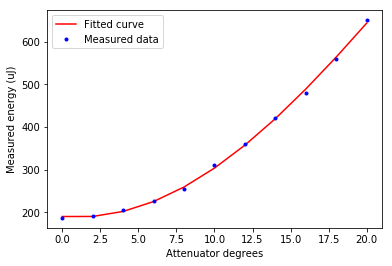

a = 786.7188980178177, b = 597.8258513090301, c = 23.473615636113376
Opening file: 
log_time = 10/20/2017 11:29:12.016, log_power = 2.168 W, att_value_sent = 1.0, sent 2017/10/20 13:26:57
Except clause entered: closing connections...


In [24]:
#adapted from: https://wiki.python.org/moin/TcpCommunication
#clientside

start_monitor('127.0.0.1', 13536, interpolation_data, target_energy) #Needs to be stopped manually